In [1]:
cycle_start = 1
PATH = "checkpoint_239.pth" # "VAE_"+str(cycle_start)+"-cycle.pth"
seeding_dataset = 'data/ChemBL-35-cleaned.csv' # initialized with 50k-ChemBL.csv
h5_input_data = 'data/1-inp.h5' # only for charset used in VAE

h5_top_0_001 = 'data/'+str(cycle_start)+'-0.001-inp.h5'
training_set_org_file = 'data/'+str(cycle_start)+'-training_set_org.csv'
latent_data_df_file = 'data/'+str(cycle_start)+'-training_set_latent_space.csv'

In [2]:
import argparse
import pandas as pd
import h5py
import numpy as np
from molecules.utils import one_hot_array, one_hot_index
from functools import reduce
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
from group_selfies import (
    fragment_mols, 
    Group, 
    MolecularGraph, 
    GroupGrammar, 
    group_encoder
)

from rdkit.Chem import rdmolfiles
from rdkit.Chem.Draw import IPythonConsole

import IPython.display # from ... import display
from test_utils import *
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*') 

import os
import sys
from rdkit.Chem import RDConfig
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit.Chem import QED
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection
     

def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    # Ensure that each element in 'vec' is a string (not numpy.bytes_)
    return "".join(map(lambda x: str(charset[x], 'utf-8') if isinstance(charset[x], bytes) else charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

In [3]:
MAX_NUM_ROWS = 100000000 #all
SMILES_COL_NAME = 'Original_SMILES' # smiles
CHUNK_SIZE = 10

class dotdict(dict): 
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

args = dotdict()
args.infile = seeding_dataset
args.outfile = h5_top_0_001
args.length = MAX_NUM_ROWS
args.smiles_column = SMILES_COL_NAME
args.property_column = "QED"

In [4]:
def chunk_iterator(dataset, chunk_size=CHUNK_SIZE):
    # Split the indices into chunks
    chunk_indices = np.array_split(np.arange(len(dataset)), len(dataset) // chunk_size)
    for chunk_ixs in chunk_indices:
        chunk = dataset[chunk_ixs]
        yield (chunk_ixs, chunk)

In [5]:
def create_chunk_dataset(h5file, dataset_name, dataset, dataset_shape,
                         chunk_size=CHUNK_SIZE, apply_fn=None):
    # Create the HDF5 dataset with the specified shape and chunk size
    new_data = h5file.create_dataset(dataset_name, dataset_shape,
                                     chunks=tuple([chunk_size] + list(dataset_shape[1:])))
    
    # Iterate through chunks
    for chunk_ixs, chunk in chunk_iterator(dataset):
        if apply_fn:
            encoded_data = np.array([list(apply_fn(i)) for i in chunk], dtype=np.float32)
        else:
            encoded_data = np.array(chunk, dtype=np.float32)

        # Assign the encoded data back into the HDF5 dataset
        new_data[chunk_ixs.tolist(), ...] = encoded_data


def one_hot_encoded_fn(row):
    # This function should return a list, not a map
    result = [one_hot_array(x, len(charset)) for x in one_hot_index(row, charset)]
    return result

def one_hot_array(i, n):
    #print(f"One hot array for index {i} of size {n}")
    return [int(ix == i) for ix in range(n)]

def one_hot_index(vec, charset):
    return [charset.index(x) for x in vec]

In [16]:
read = pd.read_csv(args.infile)
data = read.sort_values('QED').tail(int(len(read)/1000))  # top 0.1% of QED samples

In [17]:
data

,Unnamed: 0,Original_SMILES,QED,SA_score
1080945,1130811,COc1ccc(C(=O)Nc2ccc(C(F)(F)F)n(C)c2=O)cc1,0.943216,2.109209
1114318,1164437,CCC1CN(C(=O)Nc2cnn(C)c2)CCC1c1ccccc1,0.943220,2.994717
1149567,1199738,CCCc1ncc(C(=O)N2CC(=O)Nc3c(C)ccnc32)s1,0.943220,2.935510
1056445,1106204,COc1ccc(C[C@@H]2COc3ccccc3C2)cc1C(N)=O,0.943221,2.581308
987731,1037220,CN(C[C@](C)(O)c1ccccc1)C(=O)c1cc2c(o1)CCCC2,0.943221,3.095779
...,...,...,...,...
271200,280181,CN(C)CCC(=O)N1c2ccccc2NC(=O)c2ccccc21,0.948289,2.226372
2244946,2334115,Cc1c(Cl)cccc1CNC(=O)C1COc2ncccc21,0.948299,2.968532
1428821,1486679,N=C1SCC(=O)N1c1ncc(Cc2ccc(F)cc2)s1,0.948329,2.721705
1000834,1050514,CCc1cnccc1C(=O)NC1CC12CCOc1ccccc12,0.948347,3.882271


In [18]:
def load_dataset_chunked(filename, split=True, batch_size=10000):
    # Open the HDF5 file explicitly
    h5f = h5py.File(filename, 'r')

    # Memory-mapping the data (this avoids loading the entire dataset into memory at once)
    data_test = np.array(h5f['data_test'], dtype='float32', copy=False)
    
    # Handle charset as strings directly
    charset = h5f['charset']
    if charset.dtype.kind in {'S', 'O'}:  # If it's a string or object type
        charset = [x.decode('utf-8') if isinstance(x, bytes) else x for x in charset]  # Decode bytes if needed
    else:
        charset = np.array(charset, dtype='float32', copy=False)
    
    if split:
        # Instead of loading the entire data_train, we'll iterate in chunks
        data_train = h5f['data_train']
        total_samples = data_train.shape[0]
        
        # Define the generator that reads data in chunks
        def data_batch_generator():
            """Generator to load data in batches."""
            for i in range(0, total_samples, batch_size):
                batch = data_train[i:i+batch_size]  # Read a batch from disk
                yield batch

        # Return the generator, data_test, and charset
        return (data_batch_generator(), data_test, charset)
    else:
        # If not splitting, return data_test and charset only
        return (data_test, charset)
    
    # Don't forget to close the file manually when done
    h5f.close()

In [19]:
keys = data[args.smiles_column].map(len) < 121 # # Filter rows based on SMILES length

if args.length <= len(keys):
    data = data[keys].sample(n=args.length)
else:
    data = data[keys]

# Ensure that all SMILES strings are padded to 120 characters
structures = data[args.smiles_column].map(lambda x: list(x.ljust(120)))

if args.property_column:
    properties = data[args.property_column][keys]

if args.property_column2:
    properties2 = data[args.property_column2][keys]

del data  # Clean up to save memory

train_idx, test_idx = map(np.array, train_test_split(structures.index, test_size=0.1, random_state=42))

# Create the charset from the unique characters in the SMILES strings
_, _, charset = load_dataset_chunked(h5_input_data) #list(reduce(lambda x, y: set(y) | x, structures, set()))

In [20]:
args.outfile

'data/1-0.001-inp.h5'

In [21]:
with h5py.File(args.outfile, 'w') as h5f:
    h5f.create_dataset('charset', data=charset)
    print('initiated')
    # Create datasets for the training and testing data
    create_chunk_dataset(h5f, 'data_train', train_idx,
                         (len(train_idx), 120, len(charset)),
                         apply_fn=lambda ch: one_hot_encoded_fn(structures[ch]))
    print('train done')
    create_chunk_dataset(h5f, 'data_test', test_idx,
                         (len(test_idx), 120, len(charset)),
                         apply_fn=lambda ch: one_hot_encoded_fn(structures[ch]))
    print('test done')

initiated
train done
test done


# Latent data

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection


def one_hot_array(i, n):
    return map(int, [ix == i for ix in xrange(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    # Ensure that each element in 'vec' is a string (not numpy.bytes_)
    return "".join(map(lambda x: str(charset[x], 'utf-8') if isinstance(charset[x], bytes) else charset[x], vec)).strip()

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(280, 435) # changed from 70 to 280 to reflect the change of charset size
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)
        
        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 54) # changed this output from 33 to 54 to reflect the larger charset size
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar



def load_dataset_chunked(filename, split=True, batch_size=10000):
    # Open the HDF5 file explicitly
    h5f = h5py.File(filename, 'r')

    # Memory-mapping the data (this avoids loading the entire dataset into memory at once)
    data_test = np.array(h5f['data_test'], dtype='float32', copy=False)
    
    # Handle charset as strings directly
    charset = h5f['charset']
    if charset.dtype.kind in {'S', 'O'}:  # If it's a string or object type
        charset = [x.decode('utf-8') if isinstance(x, bytes) else x for x in charset]  # Decode bytes if needed
    else:
        charset = np.array(charset, dtype='float32', copy=False)
    
    if split:
        # Instead of loading the entire data_train, we'll iterate in chunks
        data_train = h5f['data_train']
        total_samples = data_train.shape[0]
        
        # Define the generator that reads data in chunks
        def data_batch_generator():
            """Generator to load data in batches."""
            for i in range(0, total_samples, batch_size):
                batch = data_train[i:i+batch_size]  # Read a batch from disk
                yield batch

        # Return the generator, data_test, and charset
        return (data_batch_generator(), data_test, charset)
    else:
        # If not splitting, return data_test and charset only
        return (data_test, charset)
    
    # Don't forget to close the file manually when done
    h5f.close()

In [23]:
class dotdict(dict):
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__
args = dotdict()
args.batch_size = 500 # was 250

import time
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MolecularVAE().to(device)

train_losses_p = []
val_losses_p = []
optimizer = optim.Adam(model.parameters(), lr=1e-4) # First 60 with 1e-3, next 60 with 5.e-4, lastly with 1.e-4

/home/jameshko/anaconda3/envs/pytorch_cuda_tensorflow/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jameshko/anaconda3/envs/pytorch_cuda_tensorflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
checkpoint = torch.load(PATH, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=280, out_features=435, bias=True)
  (linear_1): Linear(in_features=435, out_features=292, bias=True)
  (linear_2): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=54, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [25]:
def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

data_train, data_test, charset = load_dataset(h5_top_0_001)
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)

data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)

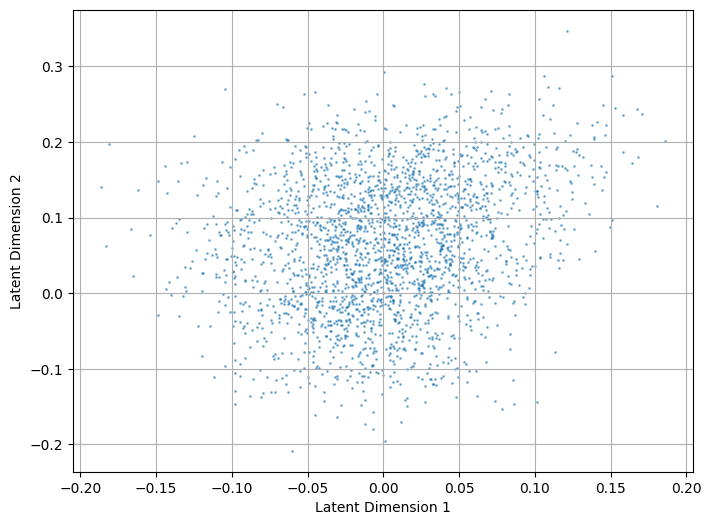

In [26]:
all_means = []
all_labels = []

model.eval()
with torch.no_grad():
    for img in train_loader:
        mean, _ = model.encode(img[0].to(device))
        all_means.append(mean.cpu())
        for imagine in img[0]:
            all_labels.append(decode_smiles_from_indexes(map(from_one_hot_array, imagine), charset))

    for img in test_loader:
        mean, _ = model.encode(img[0].to(device))
        all_means.append(mean.cpu())
        for imagine in img[0]:
            all_labels.append(decode_smiles_from_indexes(map(from_one_hot_array, imagine), charset))

latent_data = torch.cat(all_means, dim=0)

# Plotting with color coding for labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_data[:, 0], latent_data[:, 1], alpha=0.5, s=1)
#plt.title("Latent Space Representation with Labels")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
#plt.colorbar(label='Length')
plt.grid()
plt.show()

In [27]:
training_set_org = pd.DataFrame(all_labels, columns=["Original_SMILES"])
for index, row in training_set_org.iterrows():
        try:
            mol = Chem.MolFromSmiles(row['Original_SMILES'])#+'OP(C)(=O)F')
            qed = QED.default(mol)
            try:
                sas_score = sascorer.calculateScore(mol)
            except:
                sas_score = np.nan
        except:
            sas_score = np.nan
            qed = np.nan
        try:
            mol = Chem.MolFromSmiles(row['Original_SMILES']+'OP(C)(=O)F')
            qed_o = QED.default(mol)
            try:
                sas_score_o = sascorer.calculateScore(mol)
            except:
                sas_score_o = np.nan
        except:
            sas_score_o = np.nan
            qed_o = np.nan

        training_set_org.at[index, "QED"] = qed
        training_set_org.at[index, "SA_score"] = sas_score

In [28]:
training_set_org

,Original_SMILES,QED,SA_score
0,CNc1cccc(C2CCCN(C(=O)c3cscn3)C2)n1,0.946578,3.052972
1,Cc1nn(C)c(Oc2cccc(C(F)(F)F)c2)c1C(=O)O,0.944797,2.277775
2,N[C@@H](Cc1ccc(-c2ccccc2)cc1)C(=O)N1CCSC1,0.944068,2.486608
3,CC1=NN(C(=O)Cn2ccnc2)C(c2cc(Cl)ccc2O)C1,0.945214,3.157483
4,O=C(NC1(c2cccc(Cl)c2)CCCC1)c1cnccn1,0.945822,2.377029
...,...,...,...
2371,Cc1ccc(NC(=O)C2CCN(c3ncccn3)CC2)cc1F,0.946243,1.982326
2372,CC1=NN(S(=O)(=O)c2ccccc2)C(c2ccccc2O)C1,0.946254,2.767490
2373,O=C(NC1CCCCC1)c1cc(-n2cnnc2)ccc1Cl,0.948044,2.249025
2374,NCc1ncc(S(=O)(=O)c2ccc3c(c2)CCCC3)s1,0.944097,2.603352


In [29]:
training_set_org.describe()

,QED,SA_score
count,2376.000000,2376.000000
mean,0.945251,2.539181
std,0.001352,0.519882
min,0.943216,1.459705
25%,0.944030,2.129856
50%,0.945134,2.499254
75%,0.946302,2.875382
max,0.948369,4.546399


In [30]:
training_set_org.to_csv(training_set_org_file, index=False)

In [31]:
latent_data_numpy = latent_data.cpu().detach().numpy()

# Convert the numpy array to a DataFrame
latent_data_df = pd.DataFrame(latent_data_numpy)

# Save the DataFrame to a CSV file
latent_data_df.to_csv(latent_data_df_file, index=False)